# Creating realistic aggregate consumption responses [WIP]

From recent literature, we know that there are two important factors for HANK models:
1. Individual consumption responses depend on the liquid wealth distribution (how many assets you have depend on how large you respond due to precautionary and wealth effects)
2. While individual responses happen today, aggregate reponses are hump-shaped (Micro jumps and macro humps)

Therefore, to have realistic aggregate consumption reponses we need to match the liquid wealth distribution as well as incorporate (information) frictions.

## 1) Matching liquid wealth distribution

https://github.com/econ-ark/DemARK/blob/master/notebooks/Micro-and-Macro-Implications-of-Very-Impatient-HHs.ipynb


In [1]:
# !pip install tqdm

In [2]:
# This cell does some setup and imports generic tools used to produce the figures

from HARK.utilities import get_lorenz_shares, get_percentiles
from HARK.datasets import load_SCF_wealth_weights
from HARK.distribution import Uniform
# from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType
from ConsIndShockModel_HANK import IndShockConsumerType
from copy import deepcopy
import warnings
from distutils.spawn import find_executable
import matplotlib.pyplot as plt
from IPython import get_ipython  # In case it was run from python instead of ipython
from tqdm import tqdm

import numpy as np

Generator = False  # Is this notebook the master or is it generated?
# Import related generic python packages

# Set how many digits past the decimal point should be printed?


def mystr(number):
    return "{:.4f}".format(number)


def decfmt4(number):
    return "{:.4f}".format(number)


def decfmt3(number):
    return "{:.3f}".format(number)


def decfmt2(number):
    return "{:.2f}".format(number)


def decfmt1(number):
    return "{:.1f}".format(number)


# This is a jupytext paired notebook that autogenerates BufferStockTheory.py
# which can be executed from a terminal command line via "ipython BufferStockTheory.py"
# But a terminal does not permit inline figures, so we need to test jupyter vs terminal
# Google "how can I check if code is executed in the ipython notebook"


def in_ipynb():
    try:
        if (
            str(type(get_ipython()))
            == "<class 'ipykernel.zmqshell.ZMQInteractiveShell'>"
        ):
            return True
        else:
            return False
    except NameError:
        return False


# Determine whether to make the figures inline (for spyder or jupyter)
# vs whatever is the automatic setting that will apply if run from the terminal
if in_ipynb():
    # %matplotlib inline generates a syntax error when run from the shell
    # so do this instead
    get_ipython().run_line_magic("matplotlib", "inline")
else:
    get_ipython().run_line_magic("matplotlib", "auto")

# Import the plot-figure library matplotlib


# In order to use LaTeX to manage all text layout in our figures, we import rc settings from matplotlib.

plt.rc("font", family="serif")

# LaTeX is huge and takes forever to install on mybinder
# so if it is not installed then do not use it

iflatexExists = False
if find_executable("latex"):
    iflatexExists = True

plt.rc("text", usetex=iflatexExists)

# The warnings package allows us to ignore some harmless but alarming warning messages

warnings.filterwarnings("ignore")

In [3]:
# # Import IndShockConsumerType
# tau = 0
# Y_ss = 1
# T_ss = 0
# # Define a dictionary with calibrated parameters
# cstwMPC_calibrated_parameters = {
#     "CRRA": 1.0,  # Coefficient of relative risk aversion
#     "Rfree": 1.01 / (1.0 - 1.0 / 160.0),  # Survival probability,
#     # Permanent income growth factor (no perm growth),
#     "PermGroFac": [1.000**0.25],
#     "PermGroFacAgg": 1.0,
#     "BoroCnstArt": 0.0,
#     "CubicBool": False,
#     "vFuncBool": False,
#     "PermShkStd": [
#         (0.01 * 4 / 11) ** 0.5
#     ],  # Standard deviation of permanent shocks to income
#     "PermShkCount": 5,  # Number of points in permanent income shock grid
#     "TranShkStd": [
#         (0.01 * 4) ** 0.5
#     ],  # Standard deviation of transitory shocks to income,
#     "TranShkCount": 5,  # Number of points in transitory income shock grid
#     "UnempPrb": 0.07,  # Probability of unemployment while working
#     "IncUnemp": 0.15,  # Unemployment benefit replacement rate
#     "UnempPrbRet": 0.07,
#     "IncUnempRet": 0.15,
#     "aXtraMin": 0.00001,  # Minimum end-of-period assets in grid
#     # "aXtraMax": 40,  # Maximum end-of-period assets in grid
#     # "aXtraCount": 32,  # Number of points in assets grid
#     "aXtraExtra": [None],
#     "aXtraNestFac": 3,  # Number of times to 'exponentially nest' when constructing assets grid
#     "LivPrb": [1.0 - 1.0 / 160.0],  # Survival probability
#     "DiscFac": 0.97,  # Default intertemporal discount factor; dummy value, will be overwritten
#     "cycles": 0,
#     "T_cycle": 1,
#     "T_retire": 0,
#     # Number of periods to simulate (idiosyncratic shocks model, perpetual youth)
#     "T_sim": 1200,
#     "T_age": 400,
#     "IndL": 10.0 / 9.0,  # Labor supply per individual (constant),
#     "aNrmInitMean": np.log(0.00001),
#     "aNrmInitStd": 0.0,
#     "pLvlInitMean": 0.0,
#     "pLvlInitStd": 0.0,
#     "AgentCount": 10000,

#     # Parameters for constructing the "assets above minimum" grid
#     "aXtraMax" : 5000000, #500,                      # Maximum end-of-period "assets above minimum" value
#     "aXtraCount" : 500, #100,                     # Number of points in the base grid of "assets above minimum"
#     "BoroCnstArt": 0.0,

#     # HANK params
#     "taxrate" : [tau], # set to 0.0 because we are going to assume that labor here is actually after tax income
#     "labor": [Y_ss - T_ss],
#     "wage": [1.0],
    
#     # Transition Matrix simulation parameters
#     "mCount": 1300,
#     "mMax": 5000000,
#     "mMin": 0.0001,
#     "mFac": 2,
    
    
#     "labor":[1.0],
#     "wage":[1.0],
#     "tax_rate": [1.0],

#     # Hank model bool
#     "HANK":True,  
# }

# # to add taxes, labor and wage
# def function(taxrate, labor, wage):
    
#     z = (1- taxrate)*labor*wage
#     return z

# cstwMPC_calibrated_parameters['TranShkMean_Func'] = [function]


In [4]:
# Import IndShockConsumerType
tau = 0
Y_ss = 1
T_ss = 0

# to add taxes, labor and wage
def function(taxrate, labor, wage):
    
    z = (1- taxrate)*labor*wage
    return z

T = 300





### TEST MOST PATIENT AGENT START

In [5]:
# Define a dictionary with calibrated parameters
cstwMPC_calibrated_parameters = {
    "CRRA": 1.0,  # Coefficient of relative risk aversion
    "Rfree": 1.01 / (1.0 - 1.0 / 160.0),  # Survival probability,
    # Permanent income growth factor (no perm growth),
    "PermGroFac": [1.000**0.25],
    "PermGroFacAgg": 1.0,
    "BoroCnstArt": 0.0,
    "CubicBool": False,
    "vFuncBool": False,
    "PermShkStd": [
        (0.01 * 4 / 11) ** 0.5
    ],  # Standard deviation of permanent shocks to income
    "PermShkCount": 5,  # Number of points in permanent income shock grid
    "TranShkStd": [
        (0.01 * 4) ** 0.5
    ],  # Standard deviation of transitory shocks to income,
    "TranShkCount": 5,  # Number of points in transitory income shock grid
    "UnempPrb": 0.07,  # Probability of unemployment while working
    "IncUnemp": 0.15,  # Unemployment benefit replacement rate
    "UnempPrbRet": 0.07,
    "IncUnempRet": 0.15,
    "aXtraMin": 0.00001,  # Minimum end-of-period assets in grid
    # "aXtraMax": 40,  # Maximum end-of-period assets in grid
    # "aXtraCount": 32,  # Number of points in assets grid
    "aXtraExtra": [None],
    "aXtraNestFac": 3,  # Number of times to 'exponentially nest' when constructing assets grid
    "LivPrb": [1.0 - 1.0 / 160.0],  # Survival probability
    "DiscFac": 0.9928440142857142,  # Default intertemporal discount factor; dummy value, will be overwritten
    "cycles": 0,
    "T_cycle": 1,
    "T_retire": 0,
    # Number of periods to simulate (idiosyncratic shocks model, perpetual youth)
    "T_sim": 1200,
    "T_age": 400,
    "IndL": 10.0 / 9.0,  # Labor supply per individual (constant),
    "aNrmInitMean": np.log(0.00001),
    "aNrmInitStd": 0.0,
    "pLvlInitMean": 0.0,
    "pLvlInitStd": 0.0,
    "AgentCount": 10000,

    # Parameters for constructing the "assets above minimum" grid
    "aXtraMax" : 7000000, #500,                      # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 1000, #100,                     # Number of points in the base grid of "assets above minimum"

    # HANK params
    "taxrate" : [tau], # set to 0.0 because we are going to assume that labor here is actually after tax income
    "labor": [Y_ss - T_ss],
    "wage": [1.0],
    
    # Transition Matrix simulation parameters
    "mCount": 3000,
    "mMax": 7000000,
    "mMin": 0.0001,
    "mFac": 3,
    
    ### HANK model params
    "labor":[1.0],
    "wage":[1.0],
    "tax_rate": [1.0],

    # Hank model bool
    "HANK":True,  
    "TranShkMean_Func": [function],
}


In [6]:
### Baseline: mMax = aXtraMax = 10000000 (10mio) with mCount = 3000 and aXtraCount = 1000
# Low mMax (10000) and aXtraMax (1000): Jacobians are even worse
# Large mMax (10mio) and low aXtraMax (1000): Jacobians are even worse
## Works ok for: mMax = aXtraMax = 7000000 (7mio) with mCount = 3000 and aXtraCount = 1000


In [7]:
MostPatientType = IndShockConsumerType(**cstwMPC_calibrated_parameters)
MostPatientType.solve()
MostPatientType.initialize_sim()
MostPatientType.simulate()

GPFRaw                 = 1.009079 
GPFNrm                 = 1.012375 
GPFAggLivPrb           = 1.002772 
Thorn = APF            = 1.009079 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.986639 
WRPF                   = 0.069065 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


{}

In [8]:
A_ss_MostPatientType, C_ss_MostPatientType = MostPatientType.compute_steady_state()
CJACZ_MostPatientType, AJACZ_MostPatientType= MostPatientType.calc_jacobian('labor',T)
CJACR_MostPatientType, AJACR_MostPatientType= MostPatientType.calc_jacobian('Rfree',T)

GPFRaw                 = 1.009079 
GPFNrm                 = 1.012375 
GPFAggLivPrb           = 1.002772 
Thorn = APF            = 1.009079 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.986639 
WRPF                   = 0.069065 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


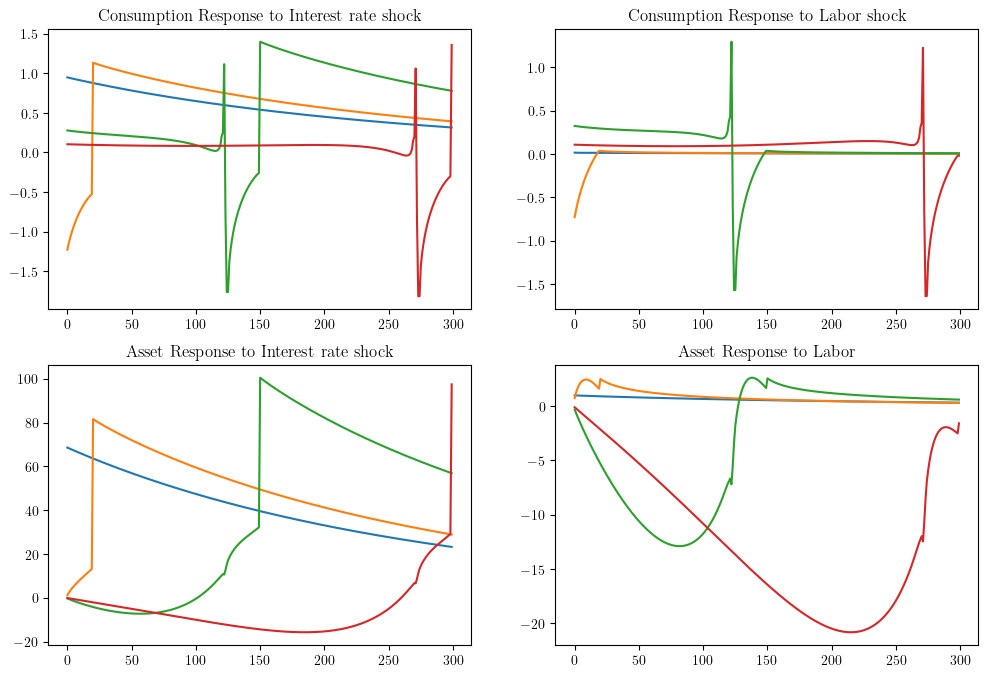

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Consumption Response to Interest rate shock
axs[0, 0].plot(CJACR_MostPatientType.T[0])
axs[0, 0].plot(CJACR_MostPatientType.T[20])
axs[0, 0].plot(CJACR_MostPatientType.T[150])
axs[0, 0].plot(CJACR_MostPatientType.T[-1])
axs[0, 0].set_title("Consumption Response to Interest rate shock")

# Consumption Response to Labor shock
axs[0, 1].plot(CJACZ_MostPatientType.T[0])
axs[0, 1].plot(CJACZ_MostPatientType.T[20])
axs[0, 1].plot(CJACZ_MostPatientType.T[150])
axs[0, 1].plot(CJACZ_MostPatientType.T[-1])
axs[0, 1].set_title("Consumption Response to Labor shock")

# Asset Response to Interest rate shock
axs[1, 0].plot(AJACR_MostPatientType.T[0])
axs[1, 0].plot(AJACR_MostPatientType.T[20])
axs[1, 0].plot(AJACR_MostPatientType.T[150])
axs[1, 0].plot(AJACR_MostPatientType.T[-1])
axs[1, 0].set_title("Asset Response to Interest rate shock")


# Asset Response to Labor
axs[1, 1].plot(AJACZ_MostPatientType.T[0])
axs[1, 1].plot(AJACZ_MostPatientType.T[20])
axs[1, 1].plot(AJACZ_MostPatientType.T[150])
axs[1, 1].plot(AJACZ_MostPatientType.T[-1])
axs[1, 1].set_title("Asset Response to Labor")

plt.show()

In [10]:
print(A_ss_MostPatientType, np.mean(MostPatientType.state_now["aLvl"][200:]))


69.95460424222081 44.279200222445105


### TEST MOST PATIENT AGENT END

In [11]:
# STOP

In [12]:
# Define a dictionary with calibrated parameters
cstwMPC_calibrated_parameters = {
    "CRRA": 1.0,  # Coefficient of relative risk aversion
    "Rfree": 1.01 / (1.0 - 1.0 / 160.0),  # Survival probability,
    # Permanent income growth factor (no perm growth),
    "PermGroFac": [1.000**0.25],
    "PermGroFacAgg": 1.0,
    "BoroCnstArt": 0.0,
    "CubicBool": False,
    "vFuncBool": False,
    "PermShkStd": [
        (0.01 * 4 / 11) ** 0.5
    ],  # Standard deviation of permanent shocks to income
    "PermShkCount": 5,  # Number of points in permanent income shock grid
    "TranShkStd": [
        (0.01 * 4) ** 0.5
    ],  # Standard deviation of transitory shocks to income,
    "TranShkCount": 5,  # Number of points in transitory income shock grid
    "UnempPrb": 0.07,  # Probability of unemployment while working
    "IncUnemp": 0.15,  # Unemployment benefit replacement rate
    "UnempPrbRet": 0.07,
    "IncUnempRet": 0.15,
    "aXtraMin": 0.00001,  # Minimum end-of-period assets in grid
    # "aXtraMax": 40,  # Maximum end-of-period assets in grid
    # "aXtraCount": 32,  # Number of points in assets grid
    "aXtraExtra": [None],
    "aXtraNestFac": 3,  # Number of times to 'exponentially nest' when constructing assets grid
    "LivPrb": [1.0 - 1.0 / 160.0],  # Survival probability
    "DiscFac": 0.9855583,  # Default intertemporal discount factor; dummy value, will be overwritten
    "cycles": 0,
    "T_cycle": 1,
    "T_retire": 0,
    # Number of periods to simulate (idiosyncratic shocks model, perpetual youth)
    "T_sim": 1200,
    "T_age": 400,
    "IndL": 10.0 / 9.0,  # Labor supply per individual (constant),
    "aNrmInitMean": np.log(0.00001),
    "aNrmInitStd": 0.0,
    "pLvlInitMean": 0.0,
    "pLvlInitStd": 0.0,
    "AgentCount": 10000,

    # Parameters for constructing the "assets above minimum" grid
    "aXtraMax" : 10000000, #500,                      # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 1000, #100,                     # Number of points in the base grid of "assets above minimum"

    # HANK params
    "taxrate" : [tau], # set to 0.0 because we are going to assume that labor here is actually after tax income
    "labor": [Y_ss - T_ss],
    "wage": [1.0],
    
    # Transition Matrix simulation parameters
    "mCount": 3000,
    "mMax": 10000000,
    "mMin": 0.0001,
    "mFac": 3,
    
    ### HANK model params
    "labor":[1.0],
    "wage":[1.0],
    "tax_rate": [1.0],

    # Hank model bool
    "HANK":True,  
    "TranShkMean_Func": [function],
}


In [13]:
# This cell constructs seven instances of IndShockConsumerType with different discount factors

BaselineType = IndShockConsumerType(**cstwMPC_calibrated_parameters)
BaselineType.solve()
BaselineType.initialize_sim()
BaselineType.simulate()


GPFRaw                 = 1.001674 
GPFNrm                 = 1.004946 
GPFAggLivPrb           = 0.995414 
Thorn = APF            = 1.001674 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.979399 
WRPF                   = 0.068558 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


{}

In [14]:
A_ss_BaselineType, C_ss_BaselineType = BaselineType.compute_steady_state()
CJACZ_BaselineType, AJACZ_BaselineType= BaselineType.calc_jacobian('labor',T)
CJACR_BaselineType, AJACR_BaselineType= BaselineType.calc_jacobian('Rfree',T)

GPFRaw                 = 1.001674 
GPFNrm                 = 1.004946 
GPFAggLivPrb           = 0.995414 
Thorn = APF            = 1.001674 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.979399 
WRPF                   = 0.068558 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


In [15]:
print(A_ss_BaselineType, np.mean(BaselineType.state_now["aLvl"]))
# print(C_ss_BaselineType, np.mean(BaselineType.state_now["cLvl"]))


1.9868889523491187 1.9779169794736888


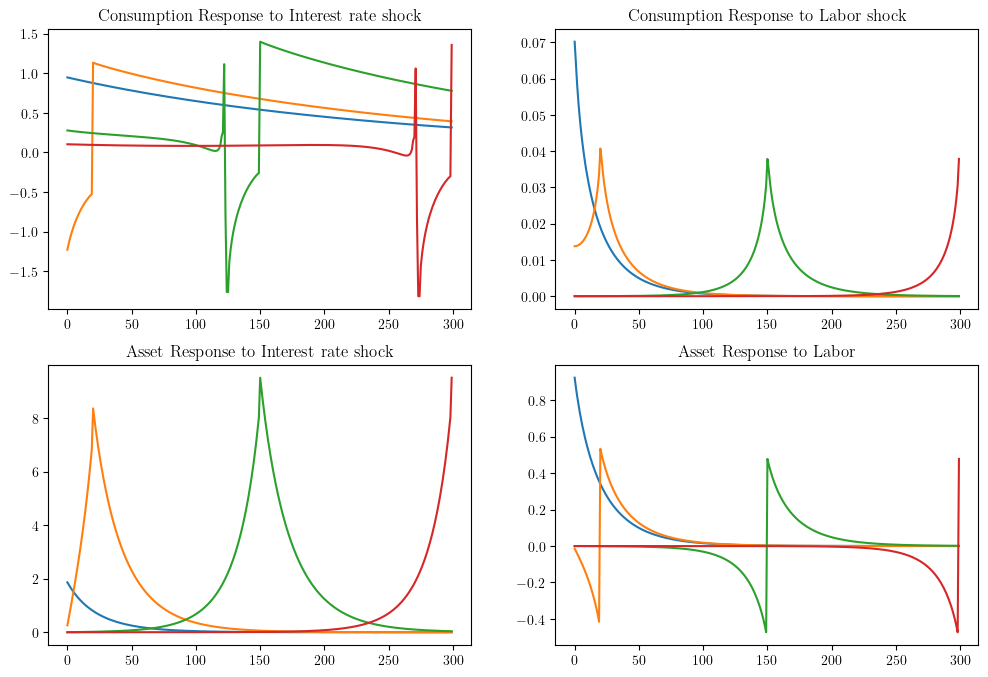

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Consumption Response to Interest rate shock
axs[0, 0].plot(CJACR_MostPatientType.T[0])
axs[0, 0].plot(CJACR_MostPatientType.T[20])
axs[0, 0].plot(CJACR_MostPatientType.T[150])
axs[0, 0].plot(CJACR_MostPatientType.T[-1])
axs[0, 0].set_title("Consumption Response to Interest rate shock")

# Consumption Response to Labor shock
axs[0, 1].plot(CJACZ_BaselineType.T[0])
axs[0, 1].plot(CJACZ_BaselineType.T[20])
axs[0, 1].plot(CJACZ_BaselineType.T[150])
axs[0, 1].plot(CJACZ_BaselineType.T[-1])
axs[0, 1].set_title("Consumption Response to Labor shock")

# Asset Response to Interest rate shock
axs[1, 0].plot(AJACR_BaselineType.T[0])
axs[1, 0].plot(AJACR_BaselineType.T[20])
axs[1, 0].plot(AJACR_BaselineType.T[150])
axs[1, 0].plot(AJACR_BaselineType.T[-1])
axs[1, 0].set_title("Asset Response to Interest rate shock")


# Asset Response to Labor
axs[1, 1].plot(AJACZ_BaselineType.T[0])
axs[1, 1].plot(AJACZ_BaselineType.T[20])
axs[1, 1].plot(AJACZ_BaselineType.T[150])
axs[1, 1].plot(AJACZ_BaselineType.T[-1])
axs[1, 1].set_title("Asset Response to Labor")

plt.show()

In [17]:
# plt.plot(CJAC_Rfree_BaselineType.T[0])
# plt.plot(CJAC_Rfree_BaselineType.T[20])
# plt.plot(CJAC_Rfree_BaselineType.T[150])
# plt.plot(CJAC_Rfree_BaselineType.T[-1])
# # plt.title("Consumption Jacobians to an interest rate shock (", DiscFac_dstn[i], ")")
# plt.show()

# plt.plot(CJAC_labor_BaselineType.T[0])
# plt.plot(CJAC_labor_BaselineType.T[20])
# plt.plot(CJAC_labor_BaselineType.T[150])
# plt.plot(CJAC_labor_BaselineType.T[-1])
# # plt.title("Consumption Jacobians to a labor shock (", DiscFac_dstn[i], ")")
# plt.show()

In [18]:
# Specify the distribution of the discount factor
num_types = 7  # number of types we want
DiscFac_mean = 0.9855583  # center of beta distribution
DiscFac_spread = 0.0085  # spread of beta distribution

# Here's how to use the tools to create time preference heterogeneity manually

DiscFac_dstn = (
    Uniform(DiscFac_mean - DiscFac_spread, DiscFac_mean + DiscFac_spread)
    .discretize(num_types)
    .atoms.flatten()
)



In [19]:
cstwMPC_calibrated_parameters_Dist = []
for i in range(num_types):
    temp_dict = deepcopy(cstwMPC_calibrated_parameters)
    temp_dict["DiscFac"] = DiscFac_dstn[i]
    cstwMPC_calibrated_parameters_Dist.append(temp_dict)

In [20]:
MyTypes = []  # initialize an empty list to hold our consumer types
for nn in range(num_types):
    # Now create the types, and append them to the list MyTypes
    NewType = IndShockConsumerType(**cstwMPC_calibrated_parameters_Dist[nn])
    NewType.update()
    # NewType.seed = nn  # give each consumer type a different RNG seed
    MyTypes.append(NewType)

In [21]:
# MyTypes = []  # initialize an empty list to hold our consumer types
# for nn in range(num_types):
#     # Now create the types, and append them to the list MyTypes
#     NewType = deepcopy(BaselineType)
#     NewType.DiscFac = DiscFac_dstn[nn]
#     NewType.update()
#     # NewType.seed = nn  # give each consumer type a different RNG seed
#     MyTypes.append(NewType)

In [22]:
# Progress bar keeps track interactively of how many have been made
CJACZ = []
AJACZ = []
CJACR = []
AJACR = []
A_ss = []
C_ss = []
for ThisType in tqdm(MyTypes):
    ThisType.solve()
    ThisType.initialize_sim()
    ThisType.simulate()
    A_ss_ThisType, C_ss_ThisType = ThisType.compute_steady_state()
    A_ss.append(A_ss_ThisType)
    C_ss.append(C_ss_ThisType)
    CJACZ_ThisType, AJACZ_ThisType= ThisType.calc_jacobian('labor',T)
    CJACR_ThisType, AJACR_ThisType= ThisType.calc_jacobian('Rfree',T)
    CJACZ.append(CJACZ_ThisType)
    AJACZ.append(AJACZ_ThisType)
    CJACR.append(CJACR_ThisType)
    AJACR.append(AJACR_ThisType)

  0%|          | 0/7 [00:00<?, ?it/s]GPFRaw                 = 0.994269 
GPFNrm                 = 0.997517 
GPFAggLivPrb           = 0.988055 
Thorn = APF            = 0.994269 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.972158 
WRPF                   = 0.068051 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


GPFRaw                 = 0.994269 
GPFNrm                 = 0.997517 
GPFAggLivPrb           = 0.988055 
Thorn = APF            = 0.994269 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.972158 
WRPF                   = 0.068051 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
 14%|█▍        | 1/7 [01:19<07:59, 79.99s/it]GPFRaw                 = 0.996738 
GPFNrm                 = 0.999994 
GPFAggLivPrb           = 0.990508 
Thorn = APF            = 0.996738 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.974572 
WRPF                   = 0.068220 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.996738 
GPFNrm                 = 0.999994 
GPFAggLivPrb           = 0.990508 
Thorn = APF            = 0.996738 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.974572 
WRPF      

In [23]:
aLvl_all = np.concatenate([ThisType.state_now["aLvl"] for ThisType in MyTypes])
print(
    "The ratio of aggregate capital to permanent income is "
    + decfmt2(np.mean(aLvl_all))
)

The ratio of aggregate capital to permanent income is 10.56


In [24]:
# Compute Lorenz shares using the brute force approach

SCF_wealth, SCF_weights = load_SCF_wealth_weights()

pctiles = np.linspace(0.001, 0.999, 200)
sim_wealth_BetaDist = np.concatenate([ThisType.state_now["aLvl"] for ThisType in MyTypes])

# Compare it with the Lorenz curve from the SCF 
SCF_Lorenz_points = get_lorenz_shares(
    SCF_wealth, weights=SCF_weights, percentiles=pctiles
)
###
sim_Lorenz_points_BetaDist = get_lorenz_shares(sim_wealth_BetaDist, percentiles=pctiles)
sim_Lorenz_points_BetaPoint = get_lorenz_shares(BaselineType.state_now["aLvl"], percentiles=pctiles)



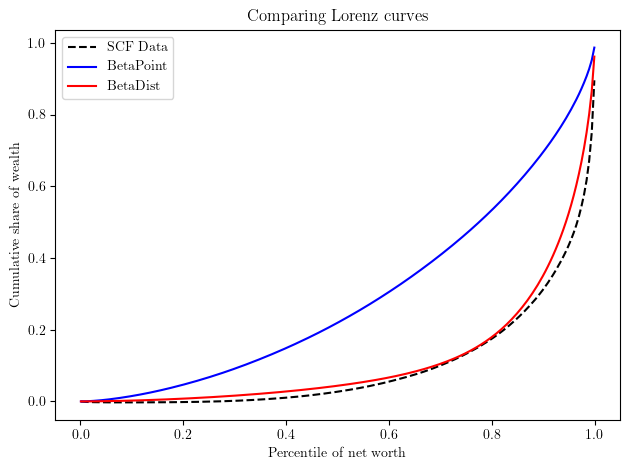

In [25]:
plt.plot(pctiles, SCF_Lorenz_points, "--k", label = "SCF Data")
plt.plot(pctiles, sim_Lorenz_points_BetaPoint, "-b", label = "BetaPoint")
plt.plot(pctiles, sim_Lorenz_points_BetaDist, "-r", label = "BetaDist")
plt.title("Comparing Lorenz curves")
plt.xlabel("Percentile of net worth")
plt.ylabel("Cumulative share of wealth")
plt.legend()
plt.tight_layout()
plt.show(block=False)

### How does the iMPC look like?

In [26]:
### Compare aggreate levels of liquid wealth
for i in range(len(MyTypes)):
    print(MyTypes[i].DiscFac)
    print(A_ss[i], np.mean(MyTypes[i].state_now["aLvl"]))# 

0.9782725857142858
1.0376772029425676 1.04445693461936
0.9807011571428572
1.1870929640389156 1.193255321856348
0.9831297285714286
1.431091942963901 1.4349958156169642
0.9855583
1.9868889523491187 1.9779169794736888
0.9879868714285714
5.783373419027335 5.377654180338387
0.9904154428571428
22.975768813099542 18.717785464654693
0.9928440142857142
69.96118126050611 44.14082030144946


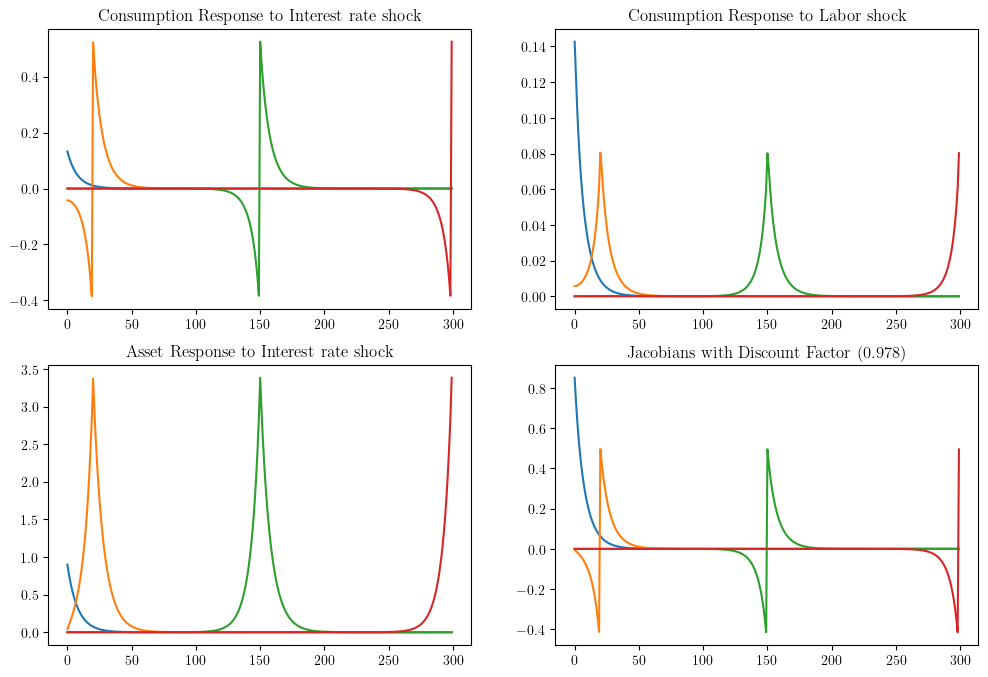

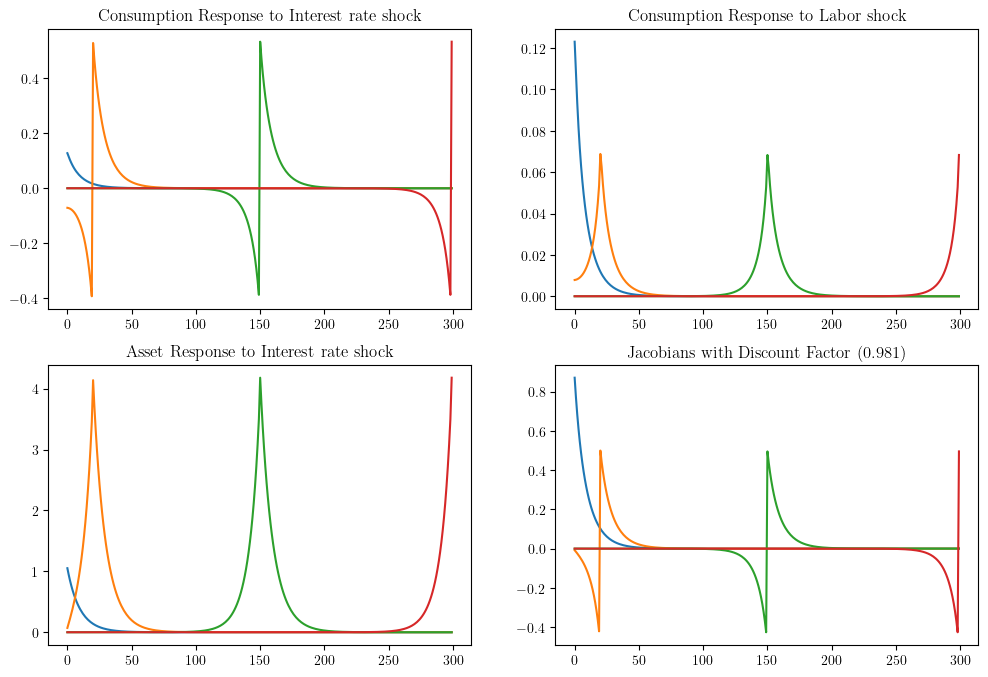

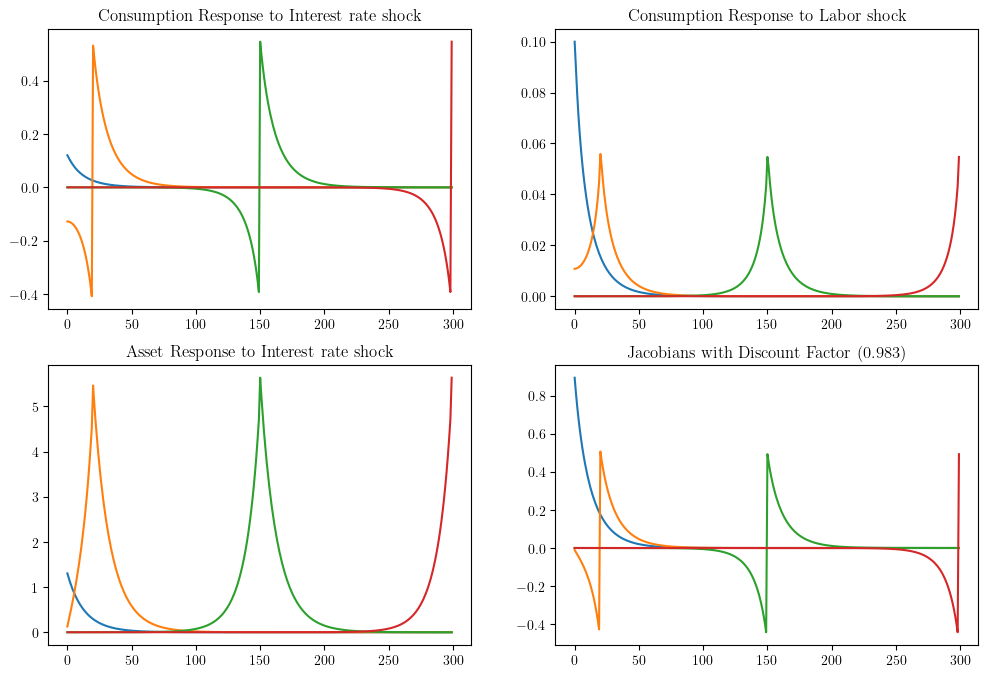

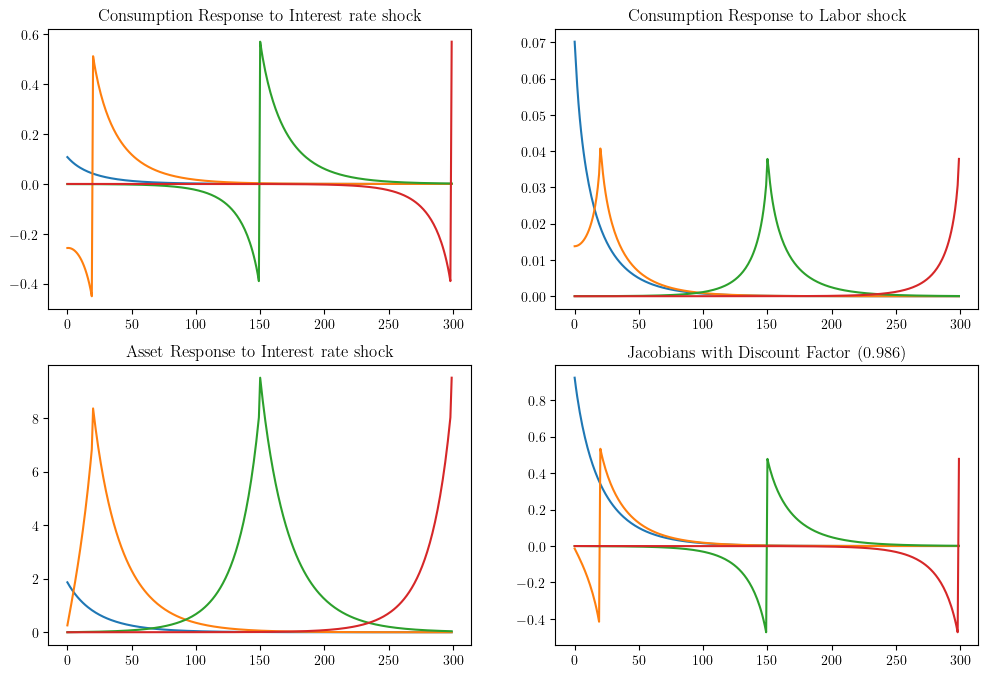

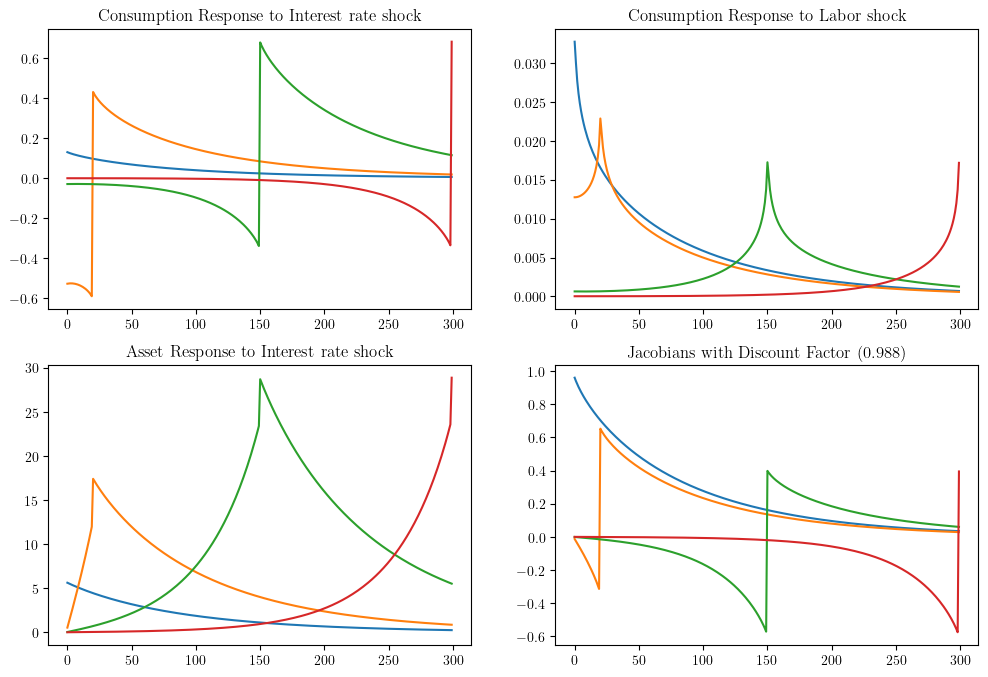

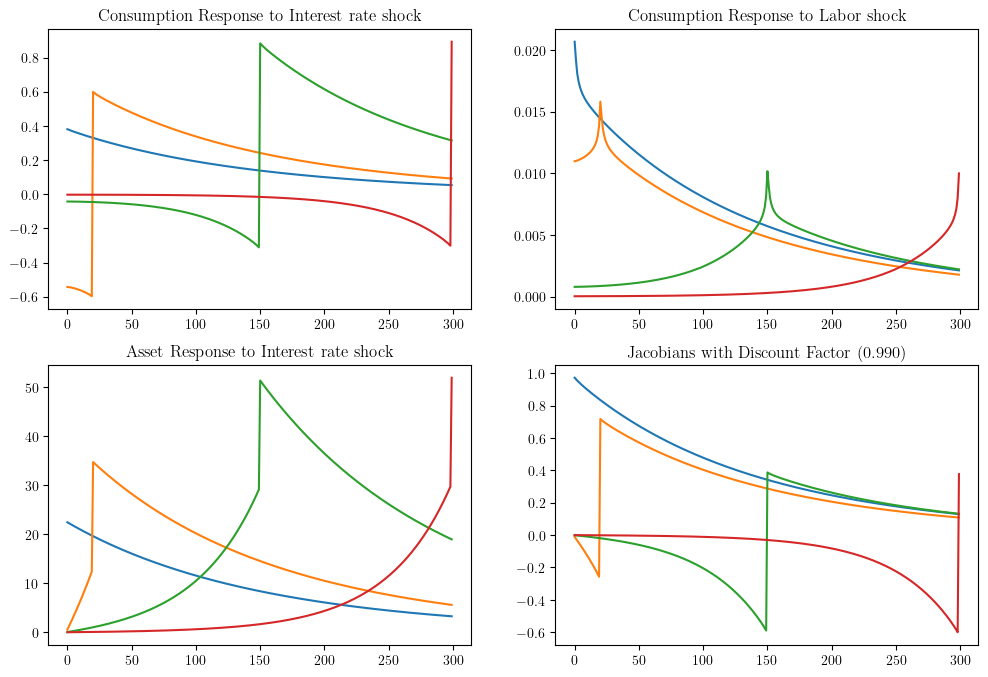

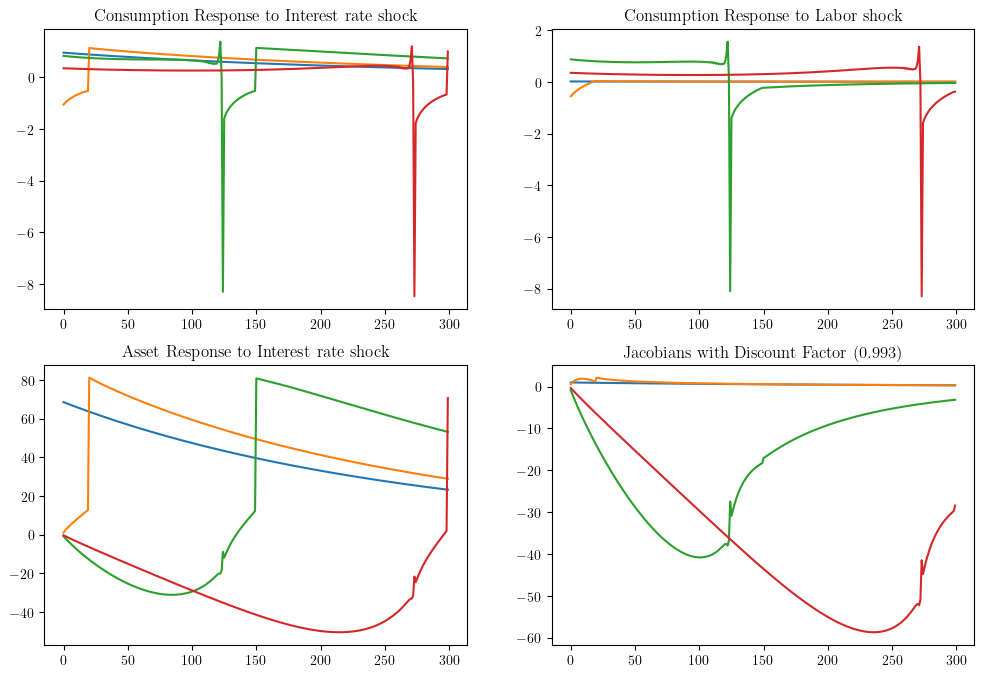

In [27]:
### Compare Jacobians for each type
for i in range(len(MyTypes)):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    # Consumption Response to Interest rate shock
    axs[0, 0].plot(CJACR[i].T[0])
    axs[0, 0].plot(CJACR[i].T[20])
    axs[0, 0].plot(CJACR[i].T[150])
    axs[0, 0].plot(CJACR[i].T[-1])
    axs[0, 0].set_title("Consumption Response to Interest rate shock")

    # Consumption Response to Labor shock
    axs[0, 1].plot(CJACZ[i].T[0])
    axs[0, 1].plot(CJACZ[i].T[20])
    axs[0, 1].plot(CJACZ[i].T[150])
    axs[0, 1].plot(CJACZ[i].T[-1])
    axs[0, 1].set_title("Consumption Response to Labor shock")

    # Asset Response to Interest rate shock
    axs[1, 0].plot(AJACR[i].T[0])
    axs[1, 0].plot(AJACR[i].T[20])
    axs[1, 0].plot(AJACR[i].T[150])
    axs[1, 0].plot(AJACR[i].T[-1])
    axs[1, 0].set_title("Asset Response to Interest rate shock")


    # Asset Response to Labor
    axs[1, 1].plot(AJACZ[i].T[0])
    axs[1, 1].plot(AJACZ[i].T[20])
    axs[1, 1].plot(AJACZ[i].T[150])
    axs[1, 1].plot(AJACZ[i].T[-1])
    axs[1, 1].set_title("Asset Response to Labor")
    plt.title("Jacobians with Discount Factor ({:.3f})".format(DiscFac_dstn[i]))
    plt.show()


In [28]:
# ### Compare Jacobians for each type
# for i in range(len(MyTypes)):
#     plt.plot(CJAC_Rfree[i].T[0])
#     plt.plot(CJAC_Rfree[i].T[20])
#     plt.plot(CJAC_Rfree[i].T[150])
#     plt.plot(CJAC_Rfree[i].T[-1])
#     plt.title("Consumption Jacobians to an interest rate shock ({:.3f})".format(DiscFac_dstn[i]))
#     plt.show()

#     plt.plot(CJAC_labor[i].T[0])
#     plt.plot(CJAC_labor[i].T[20])
#     plt.plot(CJAC_labor[i].T[150])
#     plt.plot(CJAC_labor[i].T[-1])
#     plt.title("Consumption Jacobians to a labor shock ({:.3f})".format(DiscFac_dstn[i]))
#     plt.show()



In [29]:
stop

NameError: name 'stop' is not defined

In [ ]:
# Import IndShockConsumerType
tau = 0
Y_ss = 1
T_ss = 0
# Define a dictionary with calibrated parameters
cstwMPC_calibrated_parameters0 = {
    "CRRA": 1.0,  # Coefficient of relative risk aversion
    "Rfree": 1.01 / (1.0 - 1.0 / 160.0),  # Survival probability,
    # Permanent income growth factor (no perm growth),
    "PermGroFac": [1.000**0.25],
    "PermGroFacAgg": 1.0,
    "BoroCnstArt": 0.0,
    "CubicBool": False,
    "vFuncBool": False,
    "PermShkStd": [
        (0.01 * 4 / 11) ** 0.5
    ],  # Standard deviation of permanent shocks to income
    "PermShkCount": 5,  # Number of points in permanent income shock grid
    "TranShkStd": [
        (0.01 * 4) ** 0.5
    ],  # Standard deviation of transitory shocks to income,
    "TranShkCount": 5,  # Number of points in transitory income shock grid
    "UnempPrb": 0.07,  # Probability of unemployment while working
    "IncUnemp": 0.15,  # Unemployment benefit replacement rate
    "UnempPrbRet": 0.07,
    "IncUnempRet": 0.15,
    "aXtraMin": 0.00001,  # Minimum end-of-period assets in grid
    # "aXtraMax": 40,  # Maximum end-of-period assets in grid
    # "aXtraCount": 32,  # Number of points in assets grid
    "aXtraExtra": [None],
    "aXtraNestFac": 3,  # Number of times to 'exponentially nest' when constructing assets grid
    "LivPrb": [1.0 - 1.0 / 160.0],  # Survival probability
    "DiscFac": DiscFac_dstn[0],  # Default intertemporal discount factor; dummy value, will be overwritten
    "cycles": 0,
    "T_cycle": 1,
    "T_retire": 0,
    # Number of periods to simulate (idiosyncratic shocks model, perpetual youth)
    "T_sim": 1200,
    "T_age": 400,
    "IndL": 10.0 / 9.0,  # Labor supply per individual (constant),
    "aNrmInitMean": np.log(0.00001),
    "aNrmInitStd": 0.0,
    "pLvlInitMean": 0.0,
    "pLvlInitStd": 0.0,
    "AgentCount": 10000,

    # Parameters for constructing the "assets above minimum" grid
    "aXtraMax" : 5000000, #500,                      # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 1000, #100,                     # Number of points in the base grid of "assets above minimum"

    # HANK params
    "taxrate" : [tau], # set to 0.0 because we are going to assume that labor here is actually after tax income
    "labor": [Y_ss - T_ss],
    "wage": [1.0],
    
    # Transition Matrix simulation parameters
    "mCount": 2000,
    "mMax": 5000000,
    "mMin": 0.0001,
    "mFac": 3,
    
    
    "labor":[1.0],
    "wage":[1.0],
    "tax_rate": [1.0],

    # Hank model bool
    "HANK":True,  
}

# to add taxes, labor and wage
def function(taxrate, labor, wage):
    
    z = (1- taxrate)*labor*wage
    return z

cstwMPC_calibrated_parameters0['TranShkMean_Func'] = [function]

T = 300


In [ ]:
Test0 = IndShockConsumerType(**cstwMPC_calibrated_parameters0)
Test0.solve()
Test0.initialize_sim()
Test0.simulate()
A_ss_Test0, C_ss_Test0 = Test0.compute_steady_state()
CJAC_labor_Test0, AJAC_labor_Test0= Test0.calc_jacobian('labor',T)
CJAC_Rfree_Test0, AJAC_Rfree_Test0= Test0.calc_jacobian('Rfree',T)

GPFRaw                 = 0.994269 
GPFNrm                 = 0.997517 
GPFAggLivPrb           = 0.988055 
Thorn = APF            = 0.994269 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.972158 
WRPF                   = 0.068051 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.994269 
GPFNrm                 = 0.997517 
GPFAggLivPrb           = 0.988055 
Thorn = APF            = 0.994269 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.972158 
WRPF                   = 0.068051 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


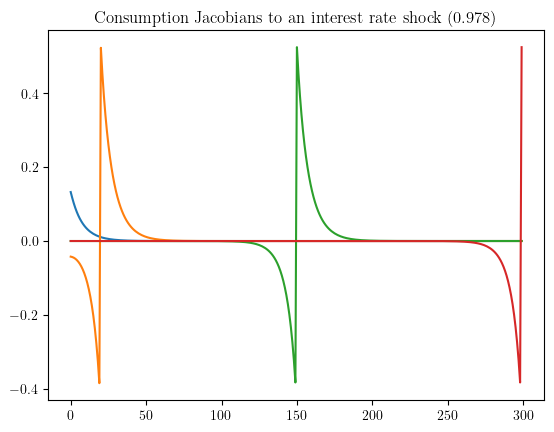

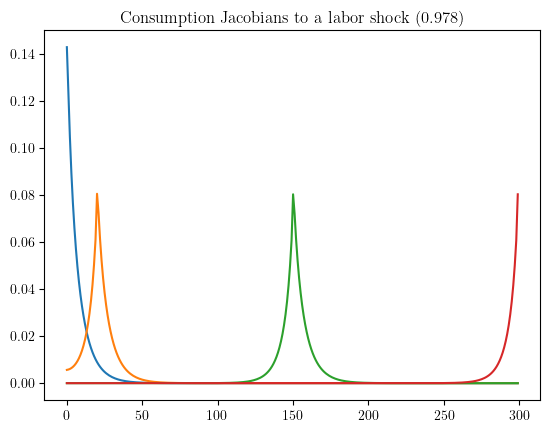

In [ ]:
plt.plot(CJAC_Rfree_Test0.T[0])
plt.plot(CJAC_Rfree_Test0.T[20])
plt.plot(CJAC_Rfree_Test0.T[150])
plt.plot(CJAC_Rfree_Test0.T[-1])
plt.title("Consumption Jacobians to an interest rate shock ({:.3f})".format(DiscFac_dstn[0]))
plt.show()

plt.plot(CJAC_labor_Test0.T[0])
plt.plot(CJAC_labor_Test0.T[20])
plt.plot(CJAC_labor_Test0.T[150])
plt.plot(CJAC_labor_Test0.T[-1])
plt.title("Consumption Jacobians to a labor shock ({:.3f})".format(DiscFac_dstn[0]))
# plt.title("Consumption Jacobians to a labor shock (", DiscFac_dstn[i], ")")
plt.show()

In [ ]:
Test1 = IndShockConsumerType(**cstwMPC_calibrated_parameters)
Test1.DiscFac = DiscFac_dstn[0]
Test1.update_income_process()
Test1.solve()
Test1.initialize_sim()
Test1.simulate()
A_ss_Test1, C_ss_Test1 = Test1.compute_steady_state()
CJAC_labor_Test1, AJAC_labor_Test1= Test1.calc_jacobian('labor',T)
CJAC_Rfree_Test1, AJAC_Rfree_Test1= Test1.calc_jacobian('Rfree',T)

GPFRaw                 = 0.994269 
GPFNrm                 = 0.997517 
GPFAggLivPrb           = 0.988055 
Thorn = APF            = 0.994269 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.972158 
WRPF                   = 0.068051 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 
GPFRaw                 = 0.994269 
GPFNrm                 = 0.997517 
GPFAggLivPrb           = 0.988055 
Thorn = APF            = 0.994269 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.972158 
WRPF                   = 0.068051 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


KeyboardInterrupt: 

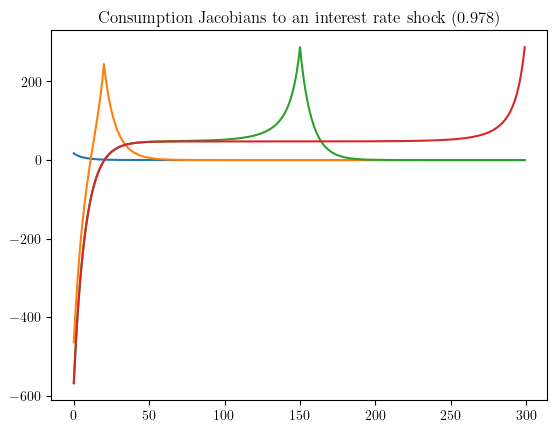

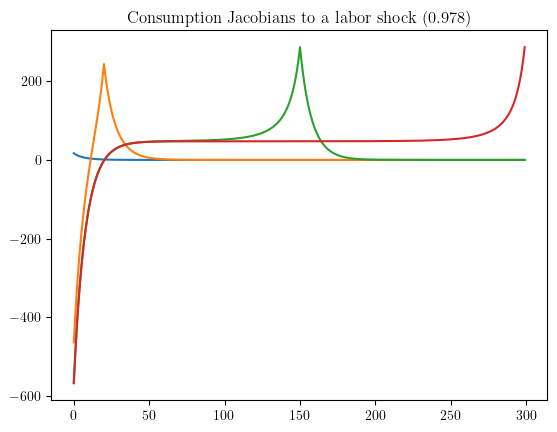

In [ ]:
plt.plot(CJAC_Rfree_Test1.T[0])
plt.plot(CJAC_Rfree_Test1.T[20])
plt.plot(CJAC_Rfree_Test1.T[150])
plt.plot(CJAC_Rfree_Test1.T[-1])
plt.title("Consumption Jacobians to an interest rate shock ({:.3f})".format(DiscFac_dstn[0]))
plt.show()

plt.plot(CJAC_labor_Test1.T[0])
plt.plot(CJAC_labor_Test1.T[20])
plt.plot(CJAC_labor_Test1.T[150])
plt.plot(CJAC_labor_Test1.T[-1])
plt.title("Consumption Jacobians to a labor shock ({:.3f})".format(DiscFac_dstn[0]))
# plt.title("Consumption Jacobians to a labor shock (", DiscFac_dstn[i], ")")
plt.show()

In [ ]:
Test1.DiscFac

0.9782725857142858

In [ ]:
    ThisType.solve()
    ThisType.initialize_sim()
    ThisType.simulate()
    A_ss_ThisType, C_ss_ThisType = ThisType.compute_steady_state()
    A_ss.append(A_ss_ThisType)
    C_ss.append(C_ss_ThisType)
    CJAC_labor_ThisType, AJAC_labor_ThisType= ThisType.calc_jacobian('labor',T)
    CJAC_Rfree_ThisType, AJAC_Rfree_ThisType= ThisType.calc_jacobian('Rfree',T)
    CJAC_labor.append(CJAC_labor_ThisType)
    AJAC_labor.append(AJAC_labor_ThisType)
    CJAC_Rfree.append(CJAC_Rfree_ThisType)
    AJAC_Rfree.append(AJAC_Rfree_ThisType)

In [ ]:
stop

NameError: name 'stop' is not defined

In [ ]:
# cstwMPC_calibrated_parameters['DiscFac'] = DiscFac_dstn[6]
# Agent_7 = IndShockConsumerType(**cstwMPC_calibrated_parameters, verbose = True)
# Agent_7.compute_steady_state()
# CJAC_labor_7, AJAC_labor_7= Agent_7.calc_jacobian('labor',T)
# CJAC_Rfree_7, AJAC_Rfree_7= Agent_7.calc_jacobian('Rfree',T)

GPFRaw                 = 1.009079 
GPFNrm                 = 1.012375 
GPFAggLivPrb           = 1.002772 
Thorn = APF            = 1.009079 
PermGroFacAdj          = 0.996744 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.986639 


WRPF                   = 0.069065 
DiscFacGPFNrmMax       = 0.980708 
DiscFacGPFAggLivPrbMax = 0.990099 


In [ ]:
# A_ss, C_ss = Agent_7.compute_steady_state()

GPFRaw                 = 1.009079 
GPFNrm                 = 1.009079 
GPFAggLivPrb           = 1.002772 
Thorn = APF            = 1.009079 
PermGroFacAdj          = 1.000000 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.986639 
WRPF                   = 0.069065 
DiscFacGPFNrmMax       = 0.983911 
DiscFacGPFAggLivPrbMax = 0.990099 


In [ ]:
# print(A_ss, np.mean(MyTypes[-1].state_now["aLvl"]))# 

33.03822416370345 43.132028732922485


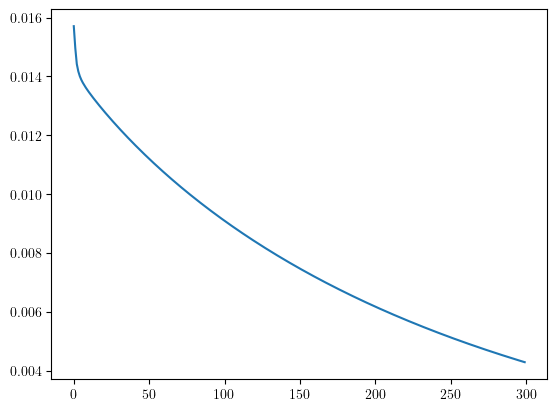

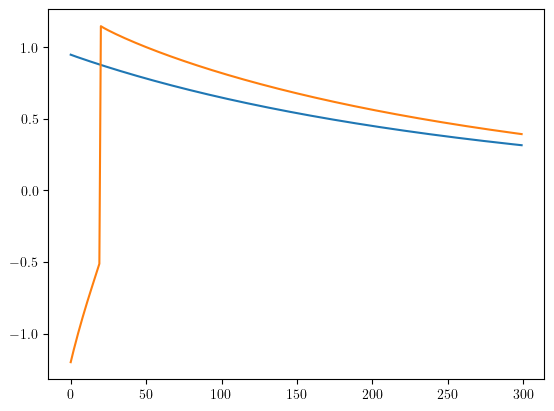

In [ ]:
# plt.plot(CJAC_labor_7.T[0])
# plt.show()
# plt.plot(CJAC_Rfree_7.T[0])
# plt.plot(CJAC_Rfree_7.T[20])
# # plt.plot(CJAC_Rfree_7.T[-1])
# plt.show()

In [ ]:
# Agent_7.LivPrb

[0.99375]

In [ ]:
stop

NameError: name 'stop' is not defined

## 2) Micro jumps and macro humps

In [ ]:
from numba import njit
@njit
def manipulate_separable(M, E):
    """ Here, E is the expectation matrix, M is the FIRE Jacobian """
    T, m = M.shape
    assert T == m
    assert E.shape == (T, T)
    
    M_beh = np.empty_like(M)
    for t in range(T):
        for s in range(T):
            summand = 0
            for tau in range(min(s,t)+1):
                if tau > 0:
                    summand += (E[tau, s] - E[tau-1, s]) * M[t - tau, s - tau]
                else:
                    summand += E[tau, s] * M[t - tau, s - tau]
            M_beh[t, s] = summand
    return M_beh

In [ ]:
def E_sticky_exp(theta, T=T, sticky_info=False):
    col = 1 - theta**(1 + np.arange(T))
    E = np.tile(col[:, np.newaxis], (1, T))
    if sticky_info:
        return E
    else:
        E = np.triu(E, +1) + np.tril(np.ones((T, T)))
        return E

In [ ]:
E_sticky_exp(0.5)[:5, :5]


In [ ]:
# Fire Expectations
Js = ha.jacobian(ss, ['r_ante', 'Y'], ['C'], T=T)

M_ha = Js['C']['Y']  # this is the Jacobian of intertemporal MPCs
Mr_ha = Js['C']['r_ante']  # this is the Jacobian of consumption to interest rates


In [ ]:
# Sticky expectations
thetas = [0, 0.4, 0.9, 1]
M_list = [manipulate_separable(M_ha, E_sticky_exp(theta)) for theta in thetas]
Mr_list = [manipulate_separable(Mr_ha, E_sticky_exp(theta)) for theta in thetas] #[Mr_ha] * len(M_list)
legend_list = ['$\\theta$ = '+str(theta) for theta in thetas]
plot_MP(Mr_list, M_list, filename='sticky_exp', legend_list=legend_list)